<a href="https://colab.research.google.com/github/smartaces/amazon-chronos-t5-sales-forecasting/blob/main/Amazon_Chronos_Time_Series_Sales_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ⏰ **Amazon Chronos Sales Forecasting** ⏰

This is a demo workbook which provides everything you need to get hands on with Amazon Chronos T5 Small using a demo ecommerce sales dataset.

**As per the Hugging Face description...**

*   'Chronos is a family of pretrained time series forecasting models based on language model architectures. Chronos models have been trained on a large corpus of publicly available time series data, as well as synthetic data generated using Gaussian processes.

**For more info see:**

*   https://huggingface.co/amazon/chronos-t5-small
*   https://github.com/amazon-science/chronos-forecasting

You can also run this on your own data if you like.

**Please Share, Cite and Connect with Me:**

If you liked or found this notebook at all helpful please share it, and simply cite me as the original source... feel free to connect with me on LinkedIn here:

https://www.linkedin.com/in/james-bentley-1b329214/


Disclaimer: This is purely for educational purposes.

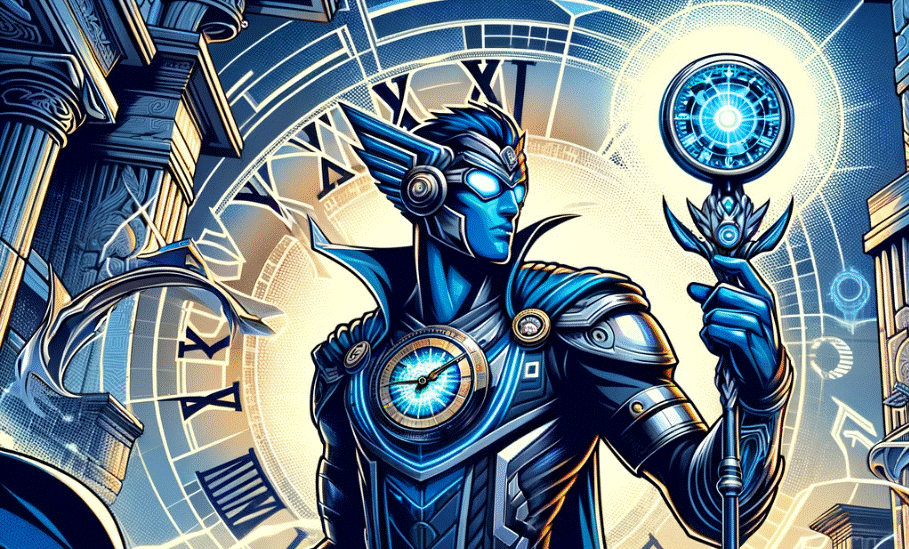

# **Install Chronos from Github**

These files are necessary to run the forecaster

*   You will also need a Hugging Face API Key, this is free and can be obtained from: https://huggingface.co/docs/hub/en/security-tokens

*   You will also need to save your Hugging Face API key to the Google secrets section of this workbook, for more info see the below screenshot and follow these instructions

*   Open your Google Colab notebook and click on the 🔑 Secrets tab in the left panel.

*   Create a new secret with the name HF_TOKEN .

*   Copy/paste your Hugging Face API key into the Value input box of HF_TOKEN .

*   Toggle the button on the left to allow notebook access to the secret.

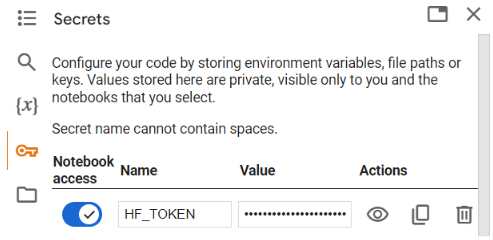

In [ ]:
# @title
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# **Upload Your CSV File From Your Computer**

It should contain two columns, the first column should contain your dates, and the second should contain the metric you would like to predict, as pictured below.

The file will be saved to a temporary location in your Google Drive, so will be deleted after your session.

You can download a copies of the csv files I use for this test here (be sure to save them as csv):

*   *Sales.csv*: https://docs.google.com/spreadsheets/d/1_tyquxKwYRWFyp0r8tMvpWoAIqJmS8fEG0wsxFT58B0/edit?usp=sharing


*   *Actual.csv*: https://docs.google.com/spreadsheets/d/1yjebWmbmY-rAyB_TDXAye8i-yoiqKA2dW_SHmtL2ihM/edit?usp=sharing








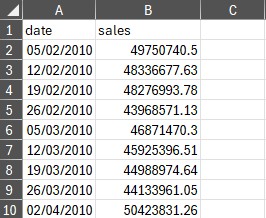

In [ ]:
# @title
#upload csv file to google drive
import os
import ipywidgets as widgets
from IPython.display import display
from google.colab import files, drive
import pandas as pd

# Define the folder path
folder_path = '/content/'

# Widget for file upload
upload_button = widgets.FileUpload(
    accept='.csv',  # Accept only CSV files
    multiple=False,  # Do not allow multiple file uploads
    description='Upload CSV File'
)

# Output widget to display file name
output = widgets.Output()

# Button to save file to Google Drive
save_button = widgets.Button(description='Save to Google Drive')

# Function to handle file upload
def on_upload_change(change):
    with output:
        output.clear_output()
        for filename, file_info in upload_button.value.items():
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'wb') as f:
                f.write(file_info['content'])
            print(f"File '{filename}' Uploaded successfully, it may take a minute to show in the files section. Or you can hit the circular arrow to refresh your files folder.")
            # Store the file path globally
            global uploaded_file_path
            uploaded_file_path = file_path

# Function to save file to Google Drive
def on_save_button_clicked(b):
    with output:
        output.clear_output()
        if 'uploaded_file_path' in globals():
            drive_file_path = '/content/drive/My Drive/' + os.path.basename(uploaded_file_path)
            os.rename(uploaded_file_path, drive_file_path)
            print(f"File saved to Google Drive at {drive_file_path}.")
        else:
            print("No file uploaded yet. Please upload a CSV file first.")

# Attach event handlers
upload_button.observe(on_upload_change, names='value')
save_button.on_click(on_save_button_clicked)

# Display widgets
display(upload_button, output)

FileUpload(value={}, accept='.csv', description='Upload CSV File')

Output()

# **Select Your CSV File To Run Forecasting On**

Ok so you just uploaded your csv, now you need to select it below and load it, so we can check it's working ok - if it is you should see the header row and four rows printed.


In [ ]:
# @title
#select your csv file to run forecasting on e.g. sales.csv
import os
import ipywidgets as widgets
import pandas as pd

# Define the folder path
folder_path = '/content/'

# List all csv files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Dropdown and button to load the csv file
csv_file_dropdown = widgets.Dropdown(options=csv_files, description='CSV Files:')
load_csv_file_button = widgets.Button(description='Load CSV File')

def on_load_csv_file_clicked(b):
    global file_path, df  # Use a global variable to store the file path and dataframe
    file_path = os.path.join(folder_path, csv_file_dropdown.value)
    df = pd.read_csv(file_path)
    print(f"File loaded: {file_path}")
    display(df.head())  # Display the first few rows of the dataframe

load_csv_file_button.on_click(on_load_csv_file_clicked)
display(csv_file_dropdown, load_csv_file_button)

Dropdown(description='CSV Files:', options=('Sales.csv',), value='Sales.csv')

Button(description='Load CSV File', style=ButtonStyle())

File loaded: /content/Sales.csv


,date,sales
0,05/02/2010,49750740.50
1,12/02/2010,48336677.63
2,19/02/2010,48276993.78
3,26/02/2010,43968571.13
4,05/03/2010,46871470.30


# **Confirm Your Column Names**

Now we just need to confirm which column contains your dates and which contains your metric, this is just so we can properly handle it based on whatever you have named them. Once selected,

In [ ]:
# @title
import pandas as pd
import ipywidgets as widgets

# Define widgets for selecting columns
date_column_dropdown = widgets.Dropdown(description='Date Column:')
sales_column_dropdown = widgets.Dropdown(description='Sales Column:')
select_columns_button = widgets.Button(description='Select Columns')

# Function to update dropdown options based on the loaded dataframe
def update_dropdown_options():
    global df  # Ensure df is defined globally
    if 'df' in globals():
        options = df.columns.tolist()
        date_column_dropdown.options = options
        sales_column_dropdown.options = options
    else:
        print("Please load a CSV file first in an earlier cell.")

# Function to save selected columns
def on_select_columns_clicked(b):
    global date_column, sales_column  # Save selections globally
    date_column = date_column_dropdown.value
    sales_column = sales_column_dropdown.value
    print(f"Selected Date Column: {date_column}, Selected Sales Column: {sales_column}")

# Update dropdown options
update_dropdown_options()

# Set up the button click event
select_columns_button.on_click(on_select_columns_clicked)

# Display widgets
display(date_column_dropdown, sales_column_dropdown, select_columns_button)


Dropdown(description='Date Column:', options=('date', 'sales'), value='date')

Dropdown(description='Sales Column:', options=('date', 'sales'), value='date')

Button(description='Select Columns', style=ButtonStyle())

Selected Date Column: date, Selected Sales Column: sales


# **Generate Forecast and CSV File**

To run your forecast you will need to confirm two settings,

1. ***The forecast length***, so this is the number of timepoints you want to run the forecast for, so for example if you wanted to run a 31 day forecast for a month, then you would select 31, if you wanted to run only 7 days next week, then you would select seven, or if you wanted to run 12 months, with one forecast for each month, you would select 12. The current default is set at 12 (to work with the demo). If you plan to assess forecast accuracy against some test data, then you should make sure that this number matches the number of date ranges you want to test against where you have data.

2. ***The Interval Period***, so this means how many days should be between each forecasted period, so if you wanted to run the forecast for consecutive days then you would select 1, if you wanted to run the forecast for each week, then you would select 7.

The forecast data  will be saved to the Google Files section as sales_forecast.csv as per the below image

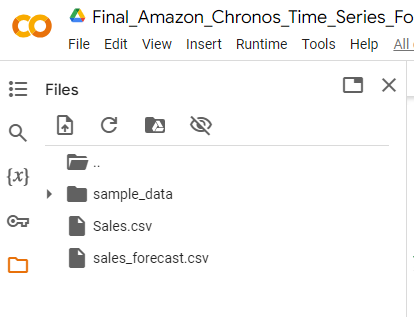

In [ ]:
# @title
import pandas as pd
import numpy as np
import torch
from google.colab import files
from chronos import ChronosPipeline
import ipywidgets as widgets
from IPython.display import display

# Widgets for interactive inputs
prediction_length_widget = widgets.Dropdown(
    options=list(range(1, 21)),
    value=12,
    description='Forecast Length:',
    disabled=False,
    style={'description_width': 'initial'}
)

forecast_interval_widget = widgets.BoundedIntText(
    value=7,
    min=1,
    max=365,
    step=1,
    description='Interval (days):',
    disabled=False,
    style={'description_width': 'initial'}
)

run_button = widgets.Button(
    description='Run Forecast',
    disabled=False,
    button_style='',
    tooltip='Click to run forecast'
)

def on_prediction_length_change(change):
    print("Forecast time period set")

def on_forecast_interval_change(change):
    print("Forecast interval days set")

prediction_length_widget.observe(on_prediction_length_change, names='value')
forecast_interval_widget.observe(on_forecast_interval_change, names='value')

display(prediction_length_widget)
display(forecast_interval_widget)
display(run_button)

# Function to run forecast when button is clicked
def run_forecast(b):
    try:
        # Ensure the selected columns are available
        if 'date_column' not in globals() or 'sales_column' not in globals():
            raise NameError("Columns not set. Please select columns in the previous cell.")

        # Ensure the dataframe `df` is available
        if 'df' not in globals():
            raise NameError("Dataframe not found. Please load the CSV in the previous cell.")

        # Use the already loaded dataframe `df` and selected columns
        df_selected = df[[date_column, sales_column]].copy()
        df_selected[date_column] = pd.to_datetime(df_selected[date_column], dayfirst=True)

        # Remove rows where date or sales are NaN
        df_selected = df_selected.dropna(subset=[date_column, sales_column])

        # Check and remove any duplicate dates if present
        if df_selected[date_column].duplicated().any():
            df_selected = df_selected.drop_duplicates(subset=date_column)

        # Validate the last date
        if pd.isna(df_selected[date_column].iloc[-1]):
            df_selected[date_column].fillna(method='ffill', inplace=True)  # Fill missing values

        # Set up the forecasting pipeline
        pipeline = ChronosPipeline.from_pretrained(
            "amazon/chronos-t5-small",
            device_map="cpu",
            torch_dtype=torch.bfloat16,
        )

        # Prepare context for prediction
        context = torch.tensor(df_selected[sales_column].values)
        prediction_length = prediction_length_widget.value
        forecast = pipeline.predict(context, prediction_length)

        # Set the forecast interval (in days)
        forecast_interval = forecast_interval_widget.value  # User defined interval

        # Ensure correct generation of forecast index
        last_date = df_selected[date_column].max()  # Use max to ensure getting the last date correctly

        forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=forecast_interval), periods=prediction_length, freq=f'{forecast_interval}D')

        # Extract forecast quantiles
        low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

        # Create a DataFrame for forecast
        forecast_df = pd.DataFrame({
            "Date": forecast_index,
            "Low": low,
            "Median": median,
            "High": high
        })

        # Combine historical and forecast data
        df_selected.set_index(date_column, inplace=True)
        forecast_df.set_index("Date", inplace=True)

        combined_df = pd.concat([df_selected, forecast_df])

        # Save to CSV
        combined_df.to_csv("/content/sales_forecast.csv")

        # Display link to download the file (works in Colab)
        files.download("/content/sales_forecast.csv")

        print('Forecast created, and sales_forecast.csv file saved to folder')

    except NameError as e:
        print(f"Error: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")
        import traceback
        traceback.print_exc()  # Print full stack trace for debugging

# Link the button to the forecast function
run_button.on_click(run_forecast)


Dropdown(description='Forecast Length:', index=11, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

BoundedIntText(value=7, description='Interval (days):', max=365, min=1, style=DescriptionStyle(description_wid…

Button(description='Run Forecast', style=ButtonStyle(), tooltip='Click to run forecast')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Forecast created, and sales_forecast.csv file saved to folder


# **Generate Forecast Chart**

This generates a trendline chart for the original sales period and the forecasted low, median and high ranges.

You can zoom in to sections by hovering over the chart, pressing  the left mouse button and selecting and area of the chart to zoom in on.

If for any reason you lose your view on the chart, simply re-run the cell again.

In [ ]:
# @title
import pandas as pd
import plotly.graph_objects as go

# Load the forecast data
forecast_path = "/content/sales_forecast.csv"
forecast_df = pd.read_csv(forecast_path)

# Rename the unnamed date column to "Date"
forecast_df.rename(columns={forecast_df.columns[0]: "Date"}, inplace=True)
forecast_df['Date'] = pd.to_datetime(forecast_df['Date'])

# Plotting the data with Plotly
fig = go.Figure()

# Extracting historical data from forecast_df
historical_df = forecast_df.dropna(subset=[sales_column])

fig.add_trace(go.Scatter(x=historical_df['Date'], y=historical_df[sales_column],
                         mode='lines', name='Historical Data', line=dict(color='royalblue')))

# Extracting forecast data
forecast_only_df = forecast_df[forecast_df['Median'].notna()]

fig.add_trace(go.Scatter(x=forecast_only_df['Date'], y=forecast_only_df['Low'],
                         mode='lines', name='Low Forecast', line=dict(color='lightgreen')))

fig.add_trace(go.Scatter(x=forecast_only_df['Date'], y=forecast_only_df['Median'],
                         mode='lines', name='Median Forecast', line=dict(color='tomato')))

fig.add_trace(go.Scatter(x=forecast_only_df['Date'], y=forecast_only_df['High'],
                         mode='lines', name='High Forecast', line=dict(color='orange')))

fig.update_layout(title='Sales Forecast',
                  xaxis_title='Date',
                  yaxis_title='Sales',
                  legend=dict(x=0, y=1, traceorder='normal'),
                  template='plotly_white')

fig.show()


# **Upload Your 'Actual' Results (in a csv file) For the Forecast Period to Google Drive**

If you want to check the accuracy of the forecaster against some real data, which you didn't include in the original sales.csv, then you can do that by uploading an actual.csv file (or whatever you choose to name it). This file should contain the actual data for the dates you ran the forecast for.

This should be a two column file with a date range in the first column, and the metric in the second column, and by comparing this to the forecast you'll be able to see what kind of accuracy it outputs.

Below is the file I use in my demo

*Actual.csv*

https://docs.google.com/spreadsheets/d/1yjebWmbmY-rAyB_TDXAye8i-yoiqKA2dW_SHmtL2ihM/edit?usp=sharing

Once the cell is run, use the file upload button to upload it to the temporary Google folder.


In [ ]:
# @title
#upload your actual results (in a csv file) for the forecast period to google drive
import os
import ipywidgets as widgets
from IPython.display import display
from google.colab import files, drive
import pandas as pd

# Define the folder path
folder_path = '/content/'

# Widget for file upload
upload_button = widgets.FileUpload(
    accept='.csv',  # Accept only CSV files
    multiple=False,  # Do not allow multiple file uploads
    description='Upload CSV File'
)

# Output widget to display file name
output = widgets.Output()

# Button to save file to Google Drive
save_button = widgets.Button(description='Save to Google Drive')

# Function to handle file upload
def on_upload_change(change):
    with output:
        output.clear_output()
        for filename, file_info in upload_button.value.items():
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'wb') as f:
                f.write(file_info['content'])
            print(f"File '{filename}' Uploaded successfully, it may take a minute to show in the files section. Or you can hit the circular arrow to refresh your files folder.")
            # Store the file path globally
            global uploaded_file_path
            uploaded_file_path = file_path

# Function to save file to Google Drive
def on_save_button_clicked(b):
    with output:
        output.clear_output()
        if 'uploaded_file_path' in globals():
            drive_file_path = '/content/drive/My Drive/' + os.path.basename(uploaded_file_path)
            os.rename(uploaded_file_path, drive_file_path)
            print(f"File saved to Google Drive at {drive_file_path}.")
        else:
            print("No file uploaded yet. Please upload a CSV file first.")

# Attach event handlers
upload_button.observe(on_upload_change, names='value')
save_button.on_click(on_save_button_clicked)

# Display widgets
display(upload_button, output)

FileUpload(value={}, accept='.csv', description='Upload CSV File')

Output()

# **Select the Actual.csv File and Confirm The Column Names**

Now you just need to select the file with the actual data in it (which you just uploaded) and confirm the column names that need to be used.

In [ ]:
# @title
import os
import pandas as pd
import ipywidgets as widgets

# Define the folder path
folder_path = '/content/'

# List all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Dropdown and button to load the actual CSV file
actual_csv_dropdown = widgets.Dropdown(options=csv_files, description='Actual CSV:')
load_actual_csv_button = widgets.Button(description='Load Actual CSV')

def on_load_actual_csv_clicked(b):
    global actual_df  # Use a global variable to store the dataframe
    actual_file_path = os.path.join(folder_path, actual_csv_dropdown.value)
    actual_df = pd.read_csv(actual_file_path)
    print(f"File loaded: {actual_file_path}")
    display(actual_df.head())  # Display the first few rows of the dataframe

    # Update the column dropdowns with the loaded dataframe's columns
    actual_date_column_dropdown.options = actual_df.columns.tolist()
    actual_sales_column_dropdown.options = actual_df.columns.tolist()

load_actual_csv_button.on_click(on_load_actual_csv_clicked)
display(actual_csv_dropdown, load_actual_csv_button)

# Define widgets for selecting columns
actual_date_column_dropdown = widgets.Dropdown(description='Date Column:')
actual_sales_column_dropdown = widgets.Dropdown(description='Sales Column:')
select_actual_columns_button = widgets.Button(description='Select Columns')

def on_select_actual_columns_clicked(b):
    global actual_date_column, actual_sales_column
    actual_date_column = actual_date_column_dropdown.value
    actual_sales_column = actual_sales_column_dropdown.value
    print(f"Selected Date Column: {actual_date_column}, Selected Sales Column: {actual_sales_column}")

select_actual_columns_button.on_click(on_select_actual_columns_clicked)
display(actual_date_column_dropdown, actual_sales_column_dropdown, select_actual_columns_button)


Dropdown(description='Actual CSV:', options=('actual.csv', 'Sales.csv', 'sales_forecast.csv'), value='actual.c…

Button(description='Load Actual CSV', style=ButtonStyle())

Dropdown(description='Date Column:', options=(), value=None)

Dropdown(description='Sales Column:', options=(), value=None)

Button(description='Select Columns', style=ButtonStyle())

File loaded: /content/actual.csv


,date,sales
0,05/02/2010,49750740.50
1,12/02/2010,48336677.63
2,19/02/2010,48276993.78
3,26/02/2010,43968571.13
4,05/03/2010,46871470.30


Selected Date Column: date, Selected Sales Column: sales


# **Generate Actual vs Forecast Trendline Chart and CSV**

Now that you have setup your actual file you can generate a trendline chart to show how the forecasts tracked vs your actual data for the forecasted date range.

A csv file is also saved to the files section called sales_forecast_with_actuals.csv, which shows the combined original data, forecasts and actuals with % variances.

In [ ]:
# @title
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from google.colab import files

try:
    # Ensure the selected columns are available
    if 'actual_date_column' not in globals() or 'actual_sales_column' not in globals():
        raise NameError("Columns not set. Please select columns in the previous cell.")

    # Ensure the dataframe `actual_df` is available
    if 'actual_df' not in globals():
        raise NameError("Dataframe not found. Please load the actual CSV in the previous cell.")

    # Load forecasted sales data
    forecast_path = '/content/sales_forecast.csv'
    forecast_df = pd.read_csv(forecast_path)

    # Correct the column name if it's blank
    if forecast_df.columns[0] == '':
        forecast_df.columns = ['Date', 'Low', 'Median', 'High']
    else:
        forecast_df.rename(columns={forecast_df.columns[0]: 'Date'}, inplace=True)

    # Use the already loaded actual dataframe `actual_df` and selected columns
    actual_df_selected = actual_df[[actual_date_column, actual_sales_column]].copy()
    actual_df_selected[actual_date_column] = pd.to_datetime(actual_df_selected[actual_date_column], dayfirst=True)
    actual_df_selected.rename(columns={actual_date_column: 'Date', actual_sales_column: 'Actual'}, inplace=True)

    # Ensure both 'Date' columns are in datetime format
    forecast_df['Date'] = pd.to_datetime(forecast_df['Date'])
    actual_df_selected['Date'] = pd.to_datetime(actual_df_selected['Date'])

    # Merge the actual sales data into the forecasted sales DataFrame based on the date
    merged_df = pd.merge(forecast_df, actual_df_selected, on='Date', how='left')

    # Replace zero values in 'Actual' column to avoid division by zero
    merged_df['Actual'].replace(0, np.nan, inplace=True)

    # Calculate the percentage variances for low, median, and high forecasts relative to the actual sales
    merged_df['Low Variance'] = (merged_df['Low'] - merged_df['Actual']) / merged_df['Actual']
    merged_df['Median Variance'] = (merged_df['Median'] - merged_df['Actual']) / merged_df['Actual']
    merged_df['High Variance'] = (merged_df['High'] - merged_df['Actual']) / merged_df['Actual']

    # Calculate the optimal adjustment to the median forecast to make it accurate to the actual sales within 1%
    merged_df['Optimal Adjustment'] = (merged_df['Actual'] - merged_df['Median']) / merged_df['Median']

    # Replace infinite values and NaN values with zero for safe calculations
    merged_df.replace([float('inf'), -float('inf'), np.nan], 0, inplace=True)

    # Remove any blank rows before the first values in the relevant columns
    relevant_columns = ['Low', 'Median', 'High', 'Low Variance', 'Median Variance', 'High Variance', 'Optimal Adjustment']
    first_valid_index = merged_df[relevant_columns].dropna(how='all').index[0]
    cleaned_df = merged_df.loc[first_valid_index:].reset_index(drop=True)

    # Save the cleaned DataFrame to a new CSV file without the Total row
    output_path = '/content/sales_forecast_with_actuals.csv'
    cleaned_df.to_csv(output_path, index=False)

    # Display link to download the file (works in Colab)
    files.download(output_path)

    # Display the first few rows of the cleaned DataFrame for verification
    display(cleaned_df.head())

    # Determine the maximum value for the y-axis scale
    max_value = cleaned_df[['Low', 'Median', 'High', 'Actual']].max().max()

    # Plot the trendlines using Plotly
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=cleaned_df['Date'], y=cleaned_df['Actual'], mode='lines+markers', name='Actual', line=dict(color='black', dash='dot')))
    fig.add_trace(go.Scatter(x=cleaned_df['Date'], y=cleaned_df['Low'], mode='lines+markers', name='Low Forecast'))
    fig.add_trace(go.Scatter(x=cleaned_df['Date'], y=cleaned_df['Median'], mode='lines+markers', name='Median Forecast'))
    fig.add_trace(go.Scatter(x=cleaned_df['Date'], y=cleaned_df['High'], mode='lines+markers', name='High Forecast'))

    fig.update_layout(
        title="Actual vs Forecasted Sales",
        xaxis_title="Date",
        yaxis_title="Sales",
        legend_title="Legend",
        font=dict(size=12),
        yaxis=dict(range=[0, max_value * 1.1])  # Set y-axis range dynamically with some padding
    )

    fig.show()

except NameError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"An error occurred: {e}")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Date,sales,Low,Median,High,Actual,Low Variance,Median Variance,High Variance,Optimal Adjustment
0,2010-02-05,49750740.50,0.0,0.0,0.0,49750740.50,0.0,0.0,0.0,0.0
1,2010-02-12,48336677.63,0.0,0.0,0.0,48336677.63,0.0,0.0,0.0,0.0
2,2010-02-19,48276993.78,0.0,0.0,0.0,48276993.78,0.0,0.0,0.0,0.0
3,2010-02-26,43968571.13,0.0,0.0,0.0,43968571.13,0.0,0.0,0.0,0.0
4,2010-03-05,46871470.30,0.0,0.0,0.0,46871470.30,0.0,0.0,0.0,0.0


# **Percentage Variance Chart for Entire Date Range**

Finally now you can also generate a bar chart which gives the overall percentage variance, for the date range, and also a summary csv file called forecast_optimal_adjustments.csv

In [ ]:
# @title
import pandas as pd
import numpy as np
import plotly.express as px
from google.colab import files

try:
    # Load the previously cleaned DataFrame
    cleaned_df = pd.read_csv('/content/sales_forecast_with_actuals.csv')

    # Filter the DataFrame to only include rows where there are non-zero values in 'Low', 'Median', or 'High'
    filtered_df = cleaned_df[(cleaned_df['Low'] != 0) | (cleaned_df['Median'] != 0) | (cleaned_df['High'] != 0)]

    # Calculate sums for the filtered data
    totals = filtered_df[["Low", "Median", "High", "Actual"]].sum().to_dict()

    # Calculate the total variances
    total_low_variance = (totals["Low"] - totals["Actual"]) / totals["Actual"] if totals["Actual"] != 0 else 0
    total_median_variance = (totals["Median"] - totals["Actual"]) / totals["Actual"] if totals["Actual"] != 0 else 0
    total_high_variance = (totals["High"] - totals["Actual"]) / totals["Actual"] if totals["Actual"] != 0 else 0
    total_optimal_adjustment = (totals["Actual"] - totals["Median"]) / totals["Median"] if totals["Median"] != 0 else 0

    # Append the totals to the filtered DataFrame
    totals_df = pd.DataFrame({
        "Date": ["Total"],
        "Low": [totals["Low"]],
        "Median": [totals["Median"]],
        "High": [totals["High"]],
        "Actual": [totals["Actual"]],
        "Low Variance": [total_low_variance],
        "Median Variance": [total_median_variance],
        "High Variance": [total_high_variance],
        "Optimal Adjustment": [total_optimal_adjustment]
    })

    final_df = pd.concat([filtered_df, totals_df], ignore_index=True)

    # Save the final DataFrame to a new CSV file
    final_output_path = '/content/forecast_optimal_adjustments.csv'
    final_df.to_csv(final_output_path, index=False)

    # Display link to download the file (works in Colab)
    files.download(final_output_path)

    # Create a bar chart for percentage variances
    bar_df = pd.DataFrame({
        'Metric': ['Low Variance', 'Median Variance', 'High Variance', 'Optimal Adjustment'],
        'Value': [total_low_variance * 100, total_median_variance * 100, total_high_variance * 100, total_optimal_adjustment * 100]
    })

    bar_fig = px.bar(bar_df, x='Metric', y='Value', title='Percentage Variances and Optimal Adjustment', labels={'Value': 'Percentage (%)'})

    bar_fig.show()

except Exception as e:
    print(f"An error occurred: {e}")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>